# Projeto: Sistema de Cálculo de Credit Score com modelo de Machine Learning.


#### Este projeto desenvolve um sistema de pontuação de crédito (credit score) utilizando técnicas de machine learning aplicadas ao conjunto de dados <a href = "https://www.kaggle.com/competitions/home-credit-default-risk">Home Credit Default Risk</a> do Kaggle. 

### Objetivo do Projeto - Desenvolver um modelo preditivo que:

 - Estime a probabilidade de inadimplência de clientes no momento da solicitação de crédito.

 - Utilize múltiplas fontes de dados (como histórico bancário, pagamentos anteriores e dívidas existentes) para enriquecer a análise.

 - Seja capaz de gerar um score interpretável, útil para decisões automatizadas de crédito.

#### Após o treinamento do modelo principal, também é realizado o treinamento de um modelo simplificado, com 14 varáveis, para a implementação de uma aplicação web de cálculo de score de crédito para clientes sem histórico registrado

##### O intuito deste arquivo notebook é apresentar uma explicação um pouco mais extensa e detalhada do que a página web, para que seja possível compreender melhor a linha de raciocínio ao longo do desenvolvimento do projeto.

# Informações sobre o dataset


Como dito anteriormente, todos os dados utilizados neste projeto foram obtidos através do site Kaggle, tendo sido disponibilizados pela instituição Home Credit. 
A base de dados inclui informações detalhadas sobre as solicitações de crédito atuais e passadas, histórico de pagamento, dívidas com outras instituições, uso de cartões de crédito e empréstimos anteriores. Através da engenharia de atributos, análise exploratória de dados (EDA) e modelagem preditiva, o sistema busca classificar os clientes entre aqueles com maior e menor risco de inadimplência.

#### Os arquivos do conjunto de dados e seus principais atributos são:

##### application_train.csv / application_test.csv 
Contém os dados principais de cada solicitação de crédito. Cada linha representa um cliente.
Colunas principais:

- SK_ID_CURR: ID único da solicitação de crédito.
- TARGET: Variável alvo (somente em train.csv) — 1 para inadimplente, 0 para adimplente.
- Informações pessoais: Gênero (CODE_GENDER), idade (DAYS_BIRTH), estado civil (NAME_FAMILY_STATUS), número de filhos (CNT_CHILDREN), tipo de moradia (NAME_HOUSING_TYPE), etc.
- Dados financeiros: Renda (AMT_INCOME_TOTAL), valor do crédito (AMT_CREDIT), valor das parcelas (AMT_ANNUITY).
- Histórico de emprego: Dias de emprego atual (DAYS_EMPLOYED).
- Fonte externa de score de crédito: EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3.

##### bureau.csv 
Informações sobre os empréstimos anteriores do cliente registrados nos bureaus de crédito.
Colunas principais:

- SK_ID_CURR: ID do cliente.
- CREDIT_ACTIVE: Status atual do crédito (ativo, encerrado).
- AMT_CREDIT_SUM: Valor atual do crédito.
- AMT_CREDIT_SUM_DEBT: Valor da dívida atual.
- CREDIT_TYPE: Tipo de crédito (empréstimo de carro, cartão, etc).

##### bureau_balance.csv 
Informações mensais sobre o status de cada crédito anterior nos bureaus. Colunas principais:

- MONTHS_BALANCE: Mês relativo à data da aplicação.
- STATUS: Status do crédito nesse mês (ativo, encerrado, atrasos DPD, etc).

##### POS_CASH_balance.csv 
Histórico mensal dos empréstimos parcelados do cliente com a empresa (ex: cartões, compras parceladas).
Colunas principais:
- CNT_INSTALMENT: Número total de parcelas.
- CNT_INSTALMENT_FUTURE: Parcelas restantes.
- NAME_CONTRACT_STATUS: Status do contrato naquele mês (ativo, fechado).
- SK_DPD: Dias de atraso.

##### credit_card_balance.csv 
Informações mensais de uso de cartão de crédito anterior. Colunas principais:
- AMT_BALANCE: Saldo atual.
- AMT_PAYMENT_CURRENT: Valor pago naquele mês.
- AMT_RECEIVABLE_PRINCIPAL: Valor principal a receber.

##### previous_application.csv 
Detalhes sobre aplicações anteriores de crédito, aprovadas ou não. Colunas principais:
- AMT_APPLICATION: Valor solicitado.
- AMT_CREDIT: Valor aprovado.
- NAME_CONTRACT_TYPE: Tipo do crédito.
- NAME_CONTRACT_STATUS: Status da aplicação (aprovado, recusado).
- SELLERPLACE_AREA, NAME_SELLER_INDUSTRY: Informações sobre o vendedor ou local da compra.

##### installments_payments.csv 
Histórico de pagamentos de parcelas dos créditos anteriores. Colunas principais:
- NUM_INSTALMENT_NUMBER: Número da parcela.
- DAYS_INSTALMENT: Quando a parcela era devida.
- DAYS_ENTRY_PAYMENT: Quando foi paga de fato.
- AMT_INSTALMENT: Valor esperado da parcela.
- AMT_PAYMENT: Valor realmente pago.

# Limpeza de Dados

O primeiro passo a ser tomado, para que possamos treinar nosso modelo de aprendizado de máquina, é transformar nossos dados a fim de garantir a sua qualidade.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import lightgbm as lgb
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier


In [2]:
pd.set_option("display.max_rows", None)  # Mostra todas as linhas
pd.set_option("display.max_columns", None)  # Mostra todas as colunas
pd.set_option("display.width", None)  # Ajusta a largura para não quebrar linhas
pd.set_option("display.max_colwidth", None)  # Mostra todo o conteúdo das colunas

In [3]:
tabelas = {
    "df_train": pd.read_csv("application_train.csv"),
    "df_test": pd.read_csv("application_test.csv"),
    "bureau": pd.read_csv("bureau.csv"),
    "bureau_balance": pd.read_csv("bureau_balance.csv"),
    "previous_application": pd.read_csv("previous_application.csv"),
    "installments_payments": pd.read_csv("installments_payments.csv"),
    "POS_CASH_balance": pd.read_csv("POS_CASH_balance.csv"),
    "credit_card_balance": pd.read_csv("credit_card_balance.csv")
}

for nome, df in tabelas.items():
    print(f"\n=== {nome.upper()} ===")
    print("Shape:", df.shape)


=== DF_TRAIN ===
Shape: (307511, 122)

=== DF_TEST ===
Shape: (48744, 121)

=== BUREAU ===
Shape: (1716428, 17)

=== BUREAU_BALANCE ===
Shape: (27299925, 3)

=== PREVIOUS_APPLICATION ===
Shape: (1670214, 37)

=== INSTALLMENTS_PAYMENTS ===
Shape: (13605401, 8)

=== POS_CASH_BALANCE ===
Shape: (10001358, 8)

=== CREDIT_CARD_BALANCE ===
Shape: (3840312, 23)


In [4]:
for nome, df in tabelas.items():
    print(f"\n=== {nome.upper()} ===")
    print("Nulos (%):\n", df.isnull().mean().sort_values(ascending=False))


=== DF_TRAIN ===
Nulos (%):
 COMMONAREA_MEDI                 0.698723
COMMONAREA_AVG                  0.698723
COMMONAREA_MODE                 0.698723
NONLIVINGAPARTMENTS_MODE        0.694330
NONLIVINGAPARTMENTS_AVG         0.694330
NONLIVINGAPARTMENTS_MEDI        0.694330
FONDKAPREMONT_MODE              0.683862
LIVINGAPARTMENTS_MODE           0.683550
LIVINGAPARTMENTS_AVG            0.683550
LIVINGAPARTMENTS_MEDI           0.683550
FLOORSMIN_AVG                   0.678486
FLOORSMIN_MODE                  0.678486
FLOORSMIN_MEDI                  0.678486
YEARS_BUILD_MEDI                0.664978
YEARS_BUILD_MODE                0.664978
YEARS_BUILD_AVG                 0.664978
OWN_CAR_AGE                     0.659908
LANDAREA_MEDI                   0.593767
LANDAREA_MODE                   0.593767
LANDAREA_AVG                    0.593767
BASEMENTAREA_MEDI               0.585160
BASEMENTAREA_AVG                0.585160
BASEMENTAREA_MODE               0.585160
EXT_SOURCE_1               

In [5]:
for nome, df in tabelas.items():
    print(f"\n=== {nome.upper()} ===")
    print("Tipos:\n", df.dtypes.value_counts())


=== DF_TRAIN ===
Tipos:
 float64    65
int64      41
object     16
Name: count, dtype: int64

=== DF_TEST ===
Tipos:
 float64    65
int64      40
object     16
Name: count, dtype: int64

=== BUREAU ===
Tipos:
 float64    8
int64      6
object     3
Name: count, dtype: int64

=== BUREAU_BALANCE ===
Tipos:
 int64     2
object    1
Name: count, dtype: int64

=== PREVIOUS_APPLICATION ===
Tipos:
 object     16
float64    15
int64       6
Name: count, dtype: int64

=== INSTALLMENTS_PAYMENTS ===
Tipos:
 float64    5
int64      3
Name: count, dtype: int64

=== POS_CASH_BALANCE ===
Tipos:
 int64      5
float64    2
object     1
Name: count, dtype: int64

=== CREDIT_CARD_BALANCE ===
Tipos:
 float64    15
int64       7
object      1
Name: count, dtype: int64


In [6]:
for nome, df in tabelas.items():
    print(f"\n=== {nome.upper()} ===")
    print("Exemplo:\n", df.head(2))


=== DF_TRAIN ===
Exemplo:
    SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           

In [7]:
for nome_tabela, df in tabelas.items():
    tabelas[nome_tabela] = df.drop_duplicates()


#### LightGBM para obter a feature importance da tabela principal

Antes de prosseguir com as demais análises, decidi utilizar um modelo de LightGBM Boost a fim de determinar, entre os 124 atributos presentes na tabela principal "df_train", quais possuem maior influência nos resultados da nossa variável alvo "TARGET". Dessa forma, as variáveis que exercem uma influência mínima serão descartadas. Quanto às outras, de maior importância, passarão por mais processos de limpeza, exploração e, por fim, treinamento do modelo final que será o preditivo de crédito dos clientes.

#### Realizando o pré processamento dos dados da tabela Train

In [8]:
from sklearn.preprocessing import LabelEncoder

df_train = tabelas["df_train"]

X = df_train.drop(columns=['TARGET'])
y = df_train['TARGET']

X_lgb = X.copy()
X_lgb = X_lgb.drop(columns=['SK_ID_CURR'])

columns_to_encode = X_lgb.select_dtypes(include='object').columns

encoders = {}

for col in columns_to_encode:

    lb = LabelEncoder()
    X_lgb[col] = lb.fit_transform(X_lgb[col])
    encoders[col] = lb

#### Treinando o modelo 

In [9]:
model = lgb.LGBMClassifier()
model.fit(X_lgb, y)

importances = pd.Series(model.feature_importances_, index=X_lgb.columns)
importances = importances.sort_values(ascending=False)


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11372
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486


In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

scores = cross_val_score(model, X_lgb, y, cv=5, scoring='roc_auc')
print(f"AUC média (cross-validation): {scores.mean():.4f}")


[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11304
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11380
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 115
[LightGBM]

Nosso rápido cálculo de AUC, que resultou em um AUC médio de 0.75, foi feito justamente para verificar se havia um "sinal" discriminativo nas nossas variáveis, mesmo antes de qualquer tratamento de nulos. Esse valor, significativamente acima de 0.5, confirma que o modelo possui uma capacidade real de discriminação, validando a existência de padrões nos dados brutos. Assim, podemos usar com confiança os resultados das feature_importances como um guia sólido para identificar as variáveis mais relevantes e garantir que não as excluiremos, mesmo com a presença de valores nulos, fornecendo uma boa base para as próximas etapas.

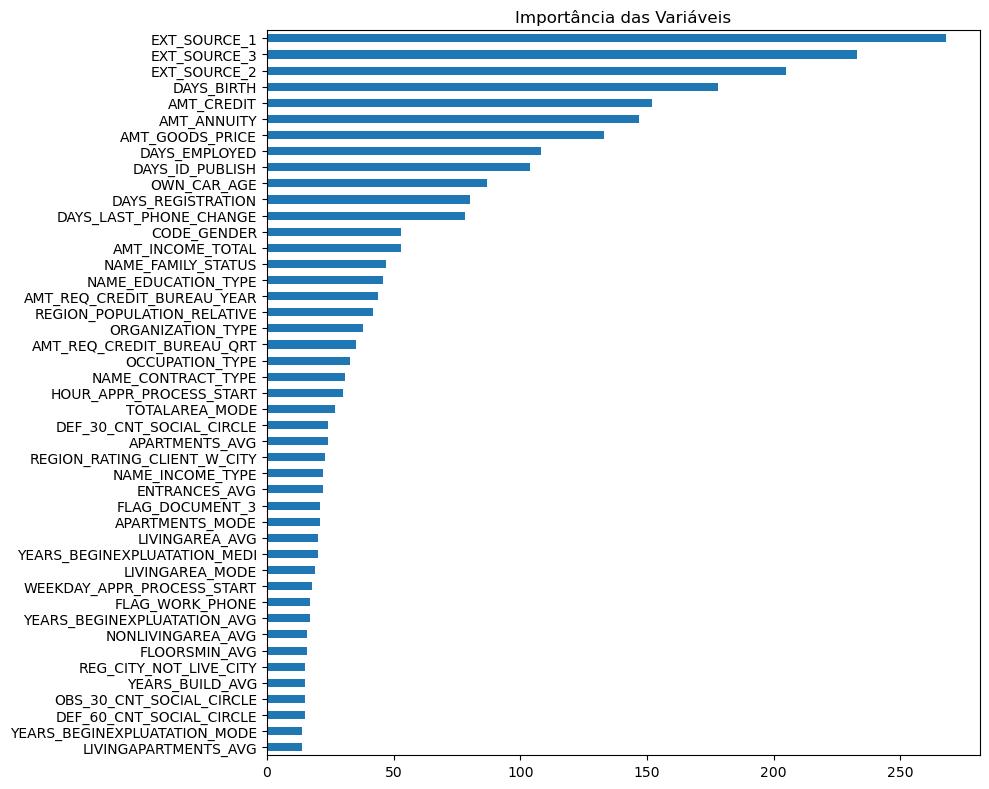

In [11]:
# Gráfico das 50 variáveis mais importantes
plt.figure(figsize=(10, 8))
importances[:45].plot(kind='barh')
plt.title('Importância das Variáveis')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Tabela das variáveis com sua importância e porcentagem de nulos
pct_nulos = df_train.isnull().mean()
df_importancia = pd.DataFrame({
    'Importância': importances,
    'Nulos (%)': pct_nulos[importances.index]
}).sort_values(by='Importância', ascending=False)


In [12]:
df_importancia

,Importância,Nulos (%)
EXT_SOURCE_1,268,0.563811
EXT_SOURCE_3,233,0.198253
EXT_SOURCE_2,205,0.002146
DAYS_BIRTH,178,0.000000
AMT_CREDIT,152,0.000000
AMT_ANNUITY,147,0.000039
AMT_GOODS_PRICE,133,0.000904
DAYS_EMPLOYED,108,0.000000
DAYS_ID_PUBLISH,104,0.000000
OWN_CAR_AGE,87,0.659908


Com a função "feature_importances", é possível observar quais variáveis foram mais importantes na construção do modelo treinado.
Como esperado, as variáveis de crédito externas têm um "peso" bastante considerável, uma vez que já carregam por si mesmas informações a respeito de risco de crédito de cada pessoa.
Outras informações como quantidades de crédito utilizadas, idade, tempo empregado, profissão, bens pessoais também possuem um impacto bastante visível nas informações obtidas. Esses resultados parecem ser bons e coerentes, poisvão ao encontro daquilo que poderíamos imaginar como fator que influencia no risco de crédito de alguém.


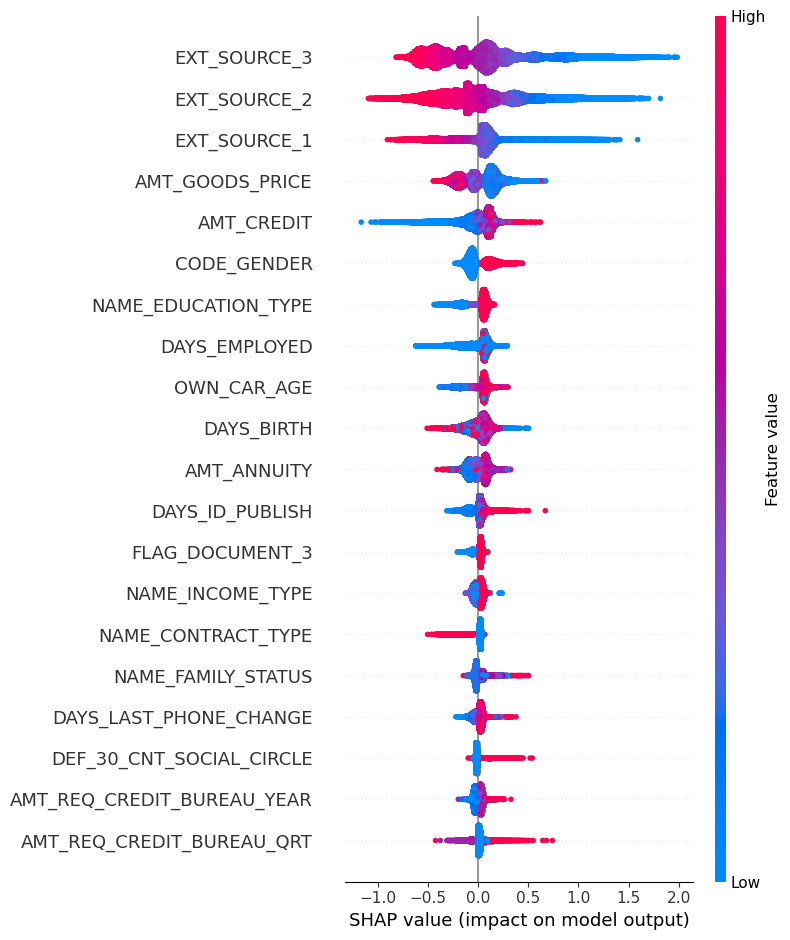

In [13]:
import shap

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_lgb)

shap.summary_plot(shap_values, X_lgb)

Nesse gráfico SHAP podemos observar que EXT_SOURCE (1, 2 e 3) continuam sendo representados como variáveis de alto impacto em nosso resultado, bem como as outras variáveis que estavam presentes em nossa tabela feita por feature_importances. Elas podem até ter trocado de posição em alguns casos se compararmos ambos os gráficos, mas isso não muda o fato de que serão importantes na hora de determinar o resultado de nossa variável alvo.

### Remoção das primeiras variáveis 

Após essa primeira análise, já é possível selecionar algumas variáveis que não possuem grande importância estatística e nem muito impacto no contexto de créditos bancários, para que sejam removidas de nossa tabela principal. Sendo assim, o modelo precisará trabalhar com menos dados, algo que melhora o desempenho computacional e também facilita as análises posteriores.

In [14]:
colunas_importancia_zero = importances[importances == 0].index.tolist()

train_limpo = df_train

train_no0 = train_limpo.drop(columns=colunas_importancia_zero)


Primeiramente removemos apenas as colunas com importância igual a zero. Nosso próximo critério será a porcentagem de zeros das colunas de menor importância.

In [15]:
colunas_a_remover = importances[(importances < 20) & (pct_nulos >= 0.47)].index.tolist()

train_no1 = train_no0.drop(columns=colunas_a_remover, errors='ignore')


In [16]:
train_no1.shape

(307511, 65)

Foram removidas as colunas cuja importância fosse menor que 20 e a porcentagem de zeros fosse maior que 47%. Isso porque, além de não terem sido muito utilizadas pelo modelo que treinamos anteriormente, grande parte de seus dados seriam imputados. Sendo assim, julguei melhor removê-los de uma vez.

### Tratamento de nulos


Agora que já removemos algumas colunas para diminuir as dimensões de nossa tabela principal, o tratamento dos valores nulos será realizado.

In [17]:
cat_cols = list(encoders.keys())  

num_cols = train_no1.columns.difference(cat_cols)

for col in cat_cols:
    if col in train_no1.columns and train_no1[col].isnull().any():
        modo = train_no1[col].mode()[0]
        train_no1[col].fillna(modo, inplace=True)

for col in num_cols:
    if train_no1[col].isnull().any():
        mediana = train_no1[col].median()
        train_no1[col].fillna(mediana, inplace=True)


### Tratamento das tabelas secundárias

Agora que já fizemos alguns tratamentos na tabela principal, a mesma coisa será feita nas tabelas secundárias, antes de juntar tudo para treinarmos nosso modelo

bureau = tabelas["bureau"]
bureau_balance = tabelas["bureau_balance"]
previous_application = tabelas["previous_application"]
installments_payments = tabelas["installments_payments"]
POS_CASH_balance = tabelas["POS_CASH_balance"]
credit_card_balance = tabelas["credit_card_balance"]

Nas tabelas secundárias, como será necessário realizar vários merge nelas, decidi que primeiro trataria seus nulos. Sendo assim, o critério que utilizarei é que colunas com mais de 70% de valores nulos serão excluídas, e as demais terão seus valores imputados.

In [18]:
tabelas_a_limpar = [
    "bureau",
    "bureau_balance",
    "previous_application",
    "installments_payments",
    "POS_CASH_balance",
    "credit_card_balance"
]
limite_nulos = 0.7

for nome_tabela in tabelas_a_limpar:
    df = tabelas[nome_tabela]
    
    pct_nulos = df.isnull().mean()
    
    colunas_remover = pct_nulos[pct_nulos > limite_nulos].index.tolist()
    
    df_limpo = df.drop(columns=colunas_remover)
    
    tabelas[nome_tabela] = df_limpo

Agora que removemos as colunas com muitos valores nulos, preencheremos todos os restantes das demais tabelas

In [19]:
tabelas_tratadas = {}

for nome in tabelas_a_limpar:
    df = tabelas[nome].copy()


    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    num_cols = df.select_dtypes(include=['number']).columns

    for col in cat_cols:
        if df[col].isnull().any():
            modo = df[col].mode()[0]
            df[col].fillna(modo, inplace=True)

    for col in num_cols:
        if df[col].isnull().any():
            mediana = df[col].median()
            df[col].fillna(mediana, inplace=True)

    tabelas_tratadas[nome] = df


Os valores nulos já foram tratados, então o merge entre as tabelas secundárias será feito

In [20]:
bureau = tabelas_tratadas["bureau"]
bureau_balance = tabelas_tratadas["bureau_balance"]
previous_application = tabelas_tratadas["previous_application"]
installments_payments = tabelas_tratadas["installments_payments"]
POS_CASH_balance = tabelas_tratadas["POS_CASH_balance"]
credit_card_balance = tabelas_tratadas["credit_card_balance"]

Ao tentar realizar o merge, me deparei com um problema: algumas das tabelas possuem mais de um registro a respeito do mesmo cliente, enquanto que, na tabela principal train, há apenas um registro por cada cliente. Sendo assim, se fez necessário juntar todos os registros em uma única linha nas tabelas em que esse problema ocorreu. Para juntar os diferentes registros de um usuário numa única linha, segui a regra de, caso a coluna fosse composta de valores numéricos, criaria novas colunas contendo a média, o valor máximo, mínimo e a soma dos registros de usuário daquela coluna.
Caso as variáveis fossem categóricas, o valor escolhido para compor o registro único seria a categoria que mais se repetisse para um usuário específico, ou seja, sua moda em cada variável. Após isso, a variável categórica é transformada em um valor numérico com o LabelEncoder.
Como são várias tabelas no dataset, resolvi fazer um código que automatizasse esse processo. Embora torne ele bastante lento computacionalmente, me poupou de ter repetir o código em várias células diferentes.

In [21]:
from sklearn.preprocessing import LabelEncoder

def agrega_tabela_completa(df, nome='tabela'):
    if 'SK_ID_CURR' not in df.columns:
        return pd.DataFrame()

    num_cols = df.select_dtypes(include='number').columns
    num_cols = num_cols.drop('SK_ID_CURR') if 'SK_ID_CURR' in num_cols else num_cols
    cat_cols = df.select_dtypes(include='object').columns

    if len(num_cols) > 0:
        df_num = df.groupby('SK_ID_CURR')[num_cols].agg(['mean', 'max', 'min', 'sum'])
        df_num.columns = [f'{nome}_' + '_'.join(col) for col in df_num.columns]
        df_num.reset_index(inplace=True)
    else:
        df_num = pd.DataFrame({'SK_ID_CURR': df['SK_ID_CURR'].unique()})

    if len(cat_cols) > 0:
        df_cat = df.groupby('SK_ID_CURR')[cat_cols].agg(
            lambda x: x.mode()[0] if not x.mode().empty else np.nan
        ).reset_index()

        for col in cat_cols:
            le = LabelEncoder()
            df_cat[col] = le.fit_transform(df_cat[col].astype(str))
    else:
        df_cat = pd.DataFrame({'SK_ID_CURR': df['SK_ID_CURR'].unique()})

    if not df_num.empty and not df_cat.empty:
        df_final = df_num.merge(df_cat, on='SK_ID_CURR', how='left')
    elif not df_num.empty:
        df_final = df_num
    elif not df_cat.empty:
        df_final = df_cat
    else:
        df_final = pd.DataFrame()

    return df_final

Fiz o merge de bureau + bureau_balance separadamente porque, quando tentei fazer a junção com todas as outras tabelas em um loop, o programa deu erro, provavelmente porque bureau_balance não possui a coluna SK_ID_BUREAU

In [22]:
print('Processando bureau + bureau_balance')

bureau_balance_agg = tabelas_tratadas['bureau_balance'].groupby('SK_ID_BUREAU').agg({
    'MONTHS_BALANCE': ['min', 'max', 'size'], 
    'STATUS': ['nunique']                     
})

bureau_balance_agg.columns = ['BUREAU_BALANCE_' + '_'.join(col) for col in bureau_balance_agg.columns]
bureau_balance_agg.reset_index(inplace=True)

bureau_merged = tabelas_tratadas['bureau'].merge(bureau_balance_agg, on='SK_ID_BUREAU', how='left')

bureau_agg = agrega_tabela_completa(bureau_merged, nome='bureau')


Processando bureau + bureau_balance


Nesse trecho terminei de fazer o merge das tabelas secundárias entre si, utilizando um loop para automatizar todo o processo. Essa parte também é muito computacionalmente custosa e leva um grande tempo para ser finalizado.

In [23]:
df_secundarias = bureau_agg.copy()

for nome, tabela in tabelas_tratadas.items():
    if nome in ['application_train', 'application_test', 'bureau', 'bureau_balance']:
        continue 

    print(f'Processando tabela: {nome}')
    tabela_agg = agrega_tabela_completa(tabela, nome=nome)

    if tabela_agg.empty or 'SK_ID_CURR' not in tabela_agg.columns:
        continue

    df_secundarias = df_secundarias.merge(tabela_agg, on='SK_ID_CURR', how='left')

Processando tabela: previous_application
Processando tabela: installments_payments
Processando tabela: POS_CASH_balance
Processando tabela: credit_card_balance


Nesse trecho, finalmente termino de juntar a tabela contendo todas as tabelas secundárias com a tabela de treino principal

In [24]:
if df_secundarias is not None and 'SK_ID_CURR' in train_no1.columns:
    df_final = train_no1.merge(df_secundarias, on='SK_ID_CURR', how='left')
else:
    df_final = tabelas_tratadas['application_train']

In [25]:
df_final.shape

(307511, 358)

#### Segunda iteração da remoção de variáveis não importantes

Agora que colocamos muitas novas colunas ao nosso modelo de treino, deveremos repetir o processo que fizemos anteriormente ao medir as importâncias de cada variável e também a porcentagem de nulos, para remover aquilo que não for muito importante

In [26]:
df_final.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE_x,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START_x,HOUR_APPR_PROCESS_START,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,ENTRANCES_AVG,LIVINGAREA_AVG,APARTMENTS_MODE,YEARS_BEGINEXPLUATATION_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,bureau_SK_ID_BUREAU_mean,bureau_SK_ID_BUREAU_max,bureau_SK_ID_BUREAU_min,bureau_SK_ID_BUREAU_sum,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_BUREAU_BALANCE_MONTHS_BALANCE_min_mean,bureau_BUREAU_BALANCE_MONTHS_BALANCE_min_max,bureau_BUREAU_BALANCE_MONTHS_BALANCE_min_min,bureau_BUREAU_BALANCE_MONTHS_BALANCE_min_sum,bureau_BUREAU_BALANCE_MONTHS_BALANCE_max_mean,bureau_BUREAU_BALANCE_MONTHS_BALANCE_max_max,bureau_BUREAU_BALANCE_MONTHS_BALANCE_max_min,bureau_BUREAU_BALANCE_MONTHS_BALANCE_max_sum,bureau_BUREAU_BALANCE_MONTHS_BALANCE_size_mean,bureau_BUREAU_BALANCE_MONTHS_BALANCE_size_max,bureau_BUREAU_BALANCE_MONTHS_BALANCE_size_min,bureau_BUREAU_BALANCE_MONTHS_BALANCE_size_sum,bureau_BUREAU_BALANCE_STATUS_nunique_mean,bureau_BUREAU_BALANCE_STATUS_nunique_max,bureau_BUREAU_BALANCE_STATUS_nunique_min,bureau_BUREAU_BALANCE_STATUS_nunique_sum,CREDIT_ACTIVE,CREDIT_CURRENCY,CREDIT_TYPE,previous_application_SK_ID_PREV_mean,previous_application_SK_ID_PREV_max,previous_application_SK_ID_PREV_min,previous_application_SK_ID_PREV_sum,previous_application_AMT_ANNUITY_mean,previous_application_AMT_ANNUITY_max,previous_application_AMT_ANNUITY_min,previous_application_AMT_ANNUITY_sum,previous_application_AMT_APPLICATION_mean,previous_application_AMT_APPLICATION_max,previous_application_AMT_APPLICATION_min,previous_application_AMT_APPLICATION_sum,previous_application_AMT_CREDIT_mean,previous_application_AMT_CREDIT_max,previous_application_AMT_CREDIT_min,previous_application_AMT_CREDIT_sum,previous_ap

In [27]:
df_final.shape

(307511, 358)

Agora, calcularei a importância de cada variável com o mesmo método que foi usado na tabela principal de treino

In [28]:
from sklearn.preprocessing import LabelEncoder
df_finalt = df_final

xf = df_finalt.drop(columns=['TARGET'])
yf = df_finalt['TARGET']

xf_lgb = xf.copy()
xf_lgb = xf_lgb.drop(columns=['SK_ID_CURR'])

columns_to_encodef = xf_lgb.select_dtypes(include='object').columns

encodersf = {}

for col in columns_to_encodef:

    lbf = LabelEncoder()
    xf_lgb[col] = lbf.fit_transform(xf_lgb[col])
    encodersf[col] = lbf

In [29]:
model_final = lgb.LGBMClassifier()
model_final.fit(xf_lgb, yf)

importances_final = pd.Series(model_final.feature_importances_, index=xf_lgb.columns)
importances_final = importances_final.sort_values(ascending=False)

[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.931284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60203
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 356
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486


In [30]:
pct_nulos2 = df_final.isnull().mean()
df_importancia2 = pd.DataFrame({
    'Importância': importances_final,
    'Nulos': pct_nulos2[importances_final.index]
}).sort_values(by='Nulos', ascending=False)

### Gráfico das 50 variáveis mais importantes

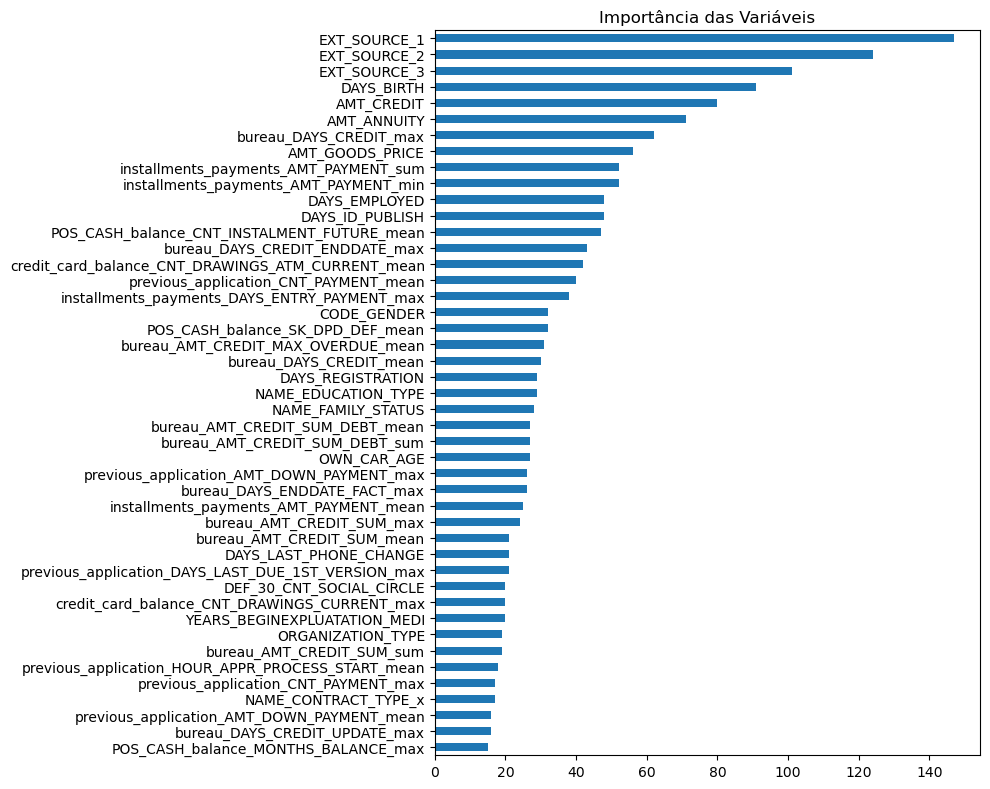

In [31]:
plt.figure(figsize=(10, 8))
importances_final[:45].plot(kind='barh')
plt.title('Importância das Variáveis')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [32]:
df_importancia2

,Importância,Nulos
NAME_CONTRACT_STATUS,0,0.755394
credit_card_balance_AMT_DRAWINGS_ATM_CURRENT_mean,9,0.755394
credit_card_balance_AMT_BALANCE_mean,3,0.755394
credit_card_balance_AMT_PAYMENT_TOTAL_CURRENT_sum,3,0.755394
credit_card_balance_AMT_INST_MIN_REGULARITY_mean,3,0.755394
credit_card_balance_AMT_DRAWINGS_ATM_CURRENT_max,3,0.755394
credit_card_balance_AMT_PAYMENT_CURRENT_mean,3,0.755394
credit_card_balance_CNT_DRAWINGS_ATM_CURRENT_max,3,0.755394
credit_card_balance_CNT_DRAWINGS_CURRENT_sum,2,0.755394
credit_card_balance_AMT_RECEIVABLE_PRINCIPAL_max,2,0.755394


Removerei todas as variáveis com importância igual a zero

In [33]:
df_final_limpo = df_final.copy()

colunas_importancia_zero2 = importances_final[importances_final == 0].index.tolist()

df_final_limpo =  df_final_limpo.drop(columns=colunas_importancia_zero2, errors = 'ignore')


Agora, removerei todas as variáveis cuja importância seja menor que 20 e a porcentagem de nulos seja maior que 75%

In [34]:
colunas_a_remover2 = importances_final[(importances_final < 20) & (pct_nulos2 >= 0.75)].index.tolist()

df_final_limpo = df_final_limpo.drop(columns=colunas_a_remover2, errors='ignore')


Agora, faremos o tratamento de zeros, usando os mesmos critérios da tabela principal

In [35]:

cat_cols = df_final_limpo.select_dtypes(include=['object', 'category']).columns
num_cols = df_final_limpo.select_dtypes(include=['number']).columns

for col in cat_cols:
    if df_final_limpo[col].isnull().any():
        modo = df_final_limpo[col].mode()[0]
        df_final_limpo[col].fillna(modo, inplace=True)

for col in num_cols:
    if df_final_limpo[col].isnull().any():
        mediana = df_final_limpo[col].median()
        df_final_limpo[col].fillna(mediana, inplace=True)


Por fim, calcularemos o valor do AUC mais uma vez, a fim de compararmos a melhora (ou piora) do poder preditivo de nosso modelo, após a incrementação de novas variáveis, em nossa tabela de treinamento.

In [36]:
from sklearn.preprocessing import LabelEncoder

aa = df_final_limpo.drop(columns=['TARGET'])
bb = df_final_limpo['TARGET']

aff = aa.copy()
aff = aff.drop(columns=['SK_ID_CURR'])

columns_to_encodefa = aff.select_dtypes(include='object').columns

encodersff = {}

for col in columns_to_encodefa:

    ff = LabelEncoder()
    aff[col] = ff.fit_transform(aff[col])
    encodersff[col] = ff

In [37]:
scoresff = cross_val_score(model, aff, bb, cv=5, scoring='roc_auc')
print(f"AUC média (cross-validation): {scoresff.mean():.4f}")


[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.528986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42235
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 235
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.514119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42155
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 235
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[Lig

Após a realização de todo o processo de feature engineering, incluindo o merge das tabelas secundárias e a geração de novas variáveis, a métrica AUC do modelo apresentou um aumento de 0,75 para 0,77. Apesar de, à primeira vista, essa variação parecer pequena, ela é, na verdade, um avanço bastante significativo dentro do contexto desse dataset.

O dataset do Home Credit Default Risk é conhecido na comunidade de ciência de dados pela sua alta complexidade, com dados ruidosos, grande volume de informações ausentes, desbalanceamento de classes e uma quantidade considerável de variáveis com baixa correlação direta com o target. Justamente por isso, é comum que melhorias na AUC aconteçam de forma incremental e sejam cada vez mais difíceis à medida que o modelo se aproxima de seu limite teórico.

Na própria competição oficial do Kaggle, a maior parte dos modelos, mesmo os que utilizaram técnicas avançadas de ensemble e feature engineering sofisticada, permaneceram na faixa de 0,76 a 0,79 de AUC, com os modelos do leaderboard ficando entre 0,80 e 0,81. Por isso, sair de 0,75 para 0,77 mostra que as novas variáveis, mesmo em meio aos "problemas" do dataset, conseguiram agregar valor preditivo ao modelo.

Esse resultado mostra que as técnicas utilizadas até o momento, apesar de amadoras, conseguiram ter um resultado relativamente satisfatório. A partir desse ponto, os ganhos adicionais tendem a ser mínimos e provavelmente exigiriam técnicas muito mais avançadas e complexas.



#### Aplicando as mesmas mudanças na tabela de teste

Juntando a tabela de teste com as tabelas secundárias

In [38]:
df_test = tabelas["df_test"]

if df_secundarias is not None and 'SK_ID_CURR' in df_test.columns:
    df_test_final = df_test.merge(df_secundarias, on='SK_ID_CURR', how='left')
else:
    df_test_final = tabelas_tratadas['application_test']

In [39]:
df_test_final.head(10)

,SK_ID_CURR,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE_x,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START_x,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,bureau_SK_ID_BUREAU_mean,bureau_SK_ID_BUREAU_max,bureau_SK_ID_BUREAU_min,bureau_SK_ID_BUREAU_sum,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_BUREAU_BALANCE_MONTHS_BALANCE_min_mean,bureau_BUREAU_BALANCE_MONTHS_BALANCE_min_max,bureau_BUREAU_BALANCE_MONTHS_BALANCE_min_min,bureau_BUREAU_BALANCE_MONTHS_BALANCE_min_sum,bureau_BUREAU_BALANCE_MONTHS_BALANCE_max_mean,bureau_BUREAU_BALANCE_MONTHS_BALANCE_max_max,bureau_BUREAU_BALANCE_MONTHS_BALANCE_max_min,bureau_BUREAU_BALANCE_MONTHS_BALANCE_max_sum,bureau_BU

In [40]:
df_test_final.shape

(48744, 414)

Agora, removerei as mesmas colunas que foram removidas da tabela principal em nossa primeira limpeza.

In [41]:
colunas_original = set(df_train.columns)
colunas_limpa = set(train_no1.columns)

colunas_removidas = colunas_original - colunas_limpa

test_no0 = df_test_final.drop(columns=colunas_removidas, errors='ignore')

In [42]:
test_no0.shape

(48744, 357)

Removendo as colunas das tabelas secundárias

In [43]:
colunas_original2 = set(df_final.columns)
colunas_limpa2 = set(df_final_limpo.columns)

colunas_removidas2 = colunas_original2 - colunas_limpa2

test_no1 = test_no0.drop(columns=colunas_removidas2, errors='ignore')

In [44]:
test_no1.shape

(48744, 236)

In [45]:
df_final_limpo.shape

(307511, 237)

Por último, faremos o tratamento de nulos na tabela de teste

In [46]:
cat_colsf = test_no1.select_dtypes(include=['object', 'category']).columns
num_colsf = test_no1.select_dtypes(include=['number']).columns

for col in cat_colsf:
    if test_no1[col].isnull().any():
        modo = test_no1[col].mode()[0]
        test_no1[col].fillna(modo, inplace=True)

for col in num_colsf:
    if test_no1[col].isnull().any():
        mediana = test_no1[col].median()
        test_no1[col].fillna(mediana, inplace=True)


In [47]:
tabela_treino = df_final_limpo
tabela_teste = test_no1

In [48]:
tabela_treino.shape

(307511, 237)

In [49]:
tabela_teste.shape

(48744, 236)

In [50]:
tabela_treino.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE_x,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,FLAG_PHONE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START_x,HOUR_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,ENTRANCES_AVG,LIVINGAREA_AVG,APARTMENTS_MODE,YEARS_BEGINEXPLUATATION_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_13,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,bureau_SK_ID_BUREAU_mean,bureau_SK_ID_BUREAU_max,bureau_SK_ID_BUREAU_min,bureau_SK_ID_BUREAU_sum,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_BUREAU_BALANCE_MONTHS_BALANCE_min_mean,bureau_BUREAU_BALANCE_MONTHS_BALANCE_min_max,bureau_BUREAU_BALANCE_MONTHS_BALANCE_min_min,bureau_BUREAU_BALANCE_MONTHS_BALANCE_min_sum,bureau_BUREAU_BALANCE_MONTHS_BALANCE_max_mean,bureau_BUREAU_BALANCE_MONTHS_BALANCE_max_max,bureau_BUREAU_BALANCE_MONTHS_BALANCE_max_min,bureau_BUREAU_BALANCE_MONTHS_BALANCE_max_sum,bureau_BUREAU_BALANCE_MONTHS_BALANCE_size_mean,bureau_BUREAU_BALANCE_MONTHS_BALANCE_size_max,bureau_BUREAU_BALANCE_MONTHS_BALANCE_size_min,bureau_BUREAU_BALANCE_MONTHS_BALANCE_size_sum,bureau_BUREAU_BALANCE_STATUS_nunique_mean,bureau_BUREAU_BALANCE_STATUS_nunique_min,bureau_BUREAU_BALANCE_STATUS_nunique_sum,CREDIT_ACTIVE,CREDIT_TYPE,previous_application_SK_ID_PREV_mean,previous_application_SK_ID_PREV_max,previous_application_SK_ID_PREV_min,previous_application_SK_ID_PREV_sum,previous_application_AMT_ANNUITY_mean,previous_application_AMT_ANNUITY_max,previous_application_AMT_ANNUITY_min,previous_application_AMT_ANNUITY_sum,previous_application_AMT_APPLICATION_mean,previous_application_AMT_APPLICATION_max,previous_application_AMT_APPLICATION_min,previous_application_AMT_APPLICATION_sum,previous_application_AMT_CREDIT_mean,previous_application_AMT_CREDIT_max,previous_application_AMT_CREDIT_min,previous_application_AMT_CREDIT_sum,previous_application_AMT_DOWN_PAYMENT_mean,previous_application_AMT_DOWN_PAYMENT_max,previous_application_AMT_DOWN_PAYMENT_sum,previous_application_AMT_GOODS_PRICE_mean,previous_application_AMT_GOODS_PRICE_max,previous_application_AMT_GOODS_PRICE_min,previous_application_HOUR_APPR_PROCESS_START_mean,previous_application_HOUR_APPR_PROCESS_START_max,previous_application_HOUR_APPR_PROCESS_START_min,previous_application_HOUR_APPR_PROCESS_START_sum,previous_application_NFLAG_LAST_APPL_IN_DAY_mean,previous_application_NFLAG_LA

# Treinamento do Modelo Final

In [51]:
tabela_treino_he = tabela_treino.drop(columns=['TARGET', 'SK_ID_CURR']) 
target_treino = tabela_treino['TARGET'] 

Separando 20% da tabela de treino para testar o modelo

In [52]:
Xtrain, Xval, ytrain, yval = train_test_split(
    tabela_treino_he, target_treino, test_size=0.2, random_state=42, stratify=y
)


#### Identifica as colunas numéricas e categóricas do conjunto de treino (Xtrain) e cria o pré-processador que aplica as transformações corretas a cada tipo de coluna

In [53]:
numeric_features = Xtrain.select_dtypes(include=np.number).columns.tolist()
categorical_features = Xtrain.select_dtypes(exclude=np.number).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

#### Cria o pipeline final, juntando o pré-processador e o modelo LightGBM e treina o pipeline com os dados de treino

In [54]:
pipeline_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMClassifier(random_state=42))
])

print("Treinando o pipeline com os dados...")
pipeline_lgbm.fit(Xtrain, ytrain)
print("Treinamento concluído!")

Treinando o pipeline com os dados...
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.150628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42505
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 339
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Treinamento concluído!


#### Cálculo do Score e exibição dos resultados

O método .predict_proba() retorna as probabilidades para cada classe [classe_0, classe_1]. Pegamos apenas a segunda coluna [:, 1], que é a probabilidade de inadimplência (TARGET=1)


In [55]:
y_pred_proba = pipeline_lgbm.predict_proba(Xval)[:, 1]

print("\n--- 10 primeiros scores de inadimplência calculados ---")
print("Cada valor representa a chance de um cliente não pagar o empréstimo:")
print(y_pred_proba[:10])

print(f"\nFormato do array de scores: {y_pred_proba.shape}")
print(f"Número de clientes no conjunto de validação: {Xval.shape[0]}")


--- 10 primeiros scores de inadimplência calculados ---
Cada valor representa a chance de um cliente não pagar o empréstimo:
[0.03188912 0.03756498 0.22921536 0.07598625 0.14126652 0.13888955
 0.01776216 0.01222794 0.32496451 0.07044359]

Formato do array de scores: (61503,)
Número de clientes no conjunto de validação: 61503


# Criação do Modelo Simplificado

Após a finalização do modelo preditivo com mais de 230 variáveis, o próximo passo foi treinar um modelo simplificado, dessa vez com apenas 14 variáveis. Elas serão fornecidas por usuários sem registro bancário que queiram calcular um score preliminar, utilizando um rápido formulário.

### Função para transformar as features coletadas

In [56]:
import joblib

def criar_features_de_risco(df):
    df_transformed = df.copy()
    #Converte colunas essenciais para numérico, tratando erros
    for col in ['AMT_CREDIT', 'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'DAYS_EMPLOYED', 'DAYS_BIRTH']:
        df_transformed[col] = pd.to_numeric(df_transformed[col], errors='coerce')
        
    #Evita divisão por zero
    df_transformed['AMT_INCOME_TOTAL'] = df_transformed['AMT_INCOME_TOTAL'].replace(0, 1)
    df_transformed['AMT_CREDIT'] = df_transformed['AMT_CREDIT'].replace(0, 1)
    
    #Cria as features
    df_transformed['CREDIT_INCOME_RATIO'] = df_transformed['AMT_CREDIT'] / df_transformed['AMT_INCOME_TOTAL']
    df_transformed['ANNUITY_INCOME_RATIO'] = df_transformed['AMT_ANNUITY'] / df_transformed['AMT_INCOME_TOTAL']
    df_transformed['CREDIT_TERM'] = df_transformed['AMT_ANNUITY'] / df_transformed['AMT_CREDIT']
    df_transformed['EMPLOYED_BIRTH_RATIO'] = df_transformed['DAYS_EMPLOYED'] / df_transformed['DAYS_BIRTH']
    
    #Substitui valores infinitos (resultado de divisões estranhas) e NaN por 0
    df_transformed.replace([np.inf, -np.inf], 0, inplace=True)
    df_transformed.fillna(0, inplace=True)
    
    return df_transformed

### Preparação dos dados

In [57]:
features_do_simulador = [
        'DAYS_BIRTH',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE',
    'CNT_CHILDREN',
    'NAME_INCOME_TYPE',
    'DAYS_EMPLOYED',
    'OCCUPATION_TYPE',
    'AMT_INCOME_TOTAL',
    'ORGANIZATION_TYPE',
    'NAME_CONTRACT_TYPE_x',
    'AMT_GOODS_PRICE',
    'AMT_CREDIT',
    'AMT_ANNUITY'
]
coluna_alvo = 'TARGET'
colunas_para_simulador = features_do_simulador + [coluna_alvo]

df_simulador = tabela_treino[colunas_para_simulador].copy()
df_simulador.dropna(inplace=True)

X_sim = df_simulador[features_do_simulador]
y_sim = df_simulador[coluna_alvo]

X_train_sim, X_val_sim, y_train_sim, y_val_sim = train_test_split(
    X_sim, y_sim, test_size=0.2, random_state=42, stratify=y_sim
)


X_train_final = criar_features_de_risco(X_train_sim)
X_val_final = criar_features_de_risco(X_val_sim)

numeric_features = X_train_sim.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train_sim.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)


### Modelo Final

In [59]:
peso = y_train_sim.value_counts()[0] / y_train_sim.value_counts()[1]

pipeline_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMClassifier(random_state=42, scale_pos_weight=peso))
])
pipeline_final.fit(X_train_final, y_train_sim)

joblib.dump(pipeline_final, 'modelo_final_deploy.joblib')
print("Arquivo .joblib foi salvo")

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Arquivo .joblib foi salvo


### Cálculo do AUC

In [60]:
modelo_carregado = joblib.load('modelo_final_deploy.joblib')

y_pred_proba_carregado = modelo_carregado.predict_proba(X_val_final)[:, 1]

auc_score_carregado = roc_auc_score(y_val_sim, y_pred_proba_carregado)

print(f"AUC: {auc_score_carregado:.4f}")

AUC: 0.6975


Após a realização de todos os passos acima, o modelo está finalmente pronto para ser integrado a uma interface web interativa

## Caso tenha interesse, acesse a interface web pelo link: <a href = "https://gloriaxgz.vercel.app/projeto-score-credito.html"> Simulador de Crédito </a>